In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Fonctions de prétraitement du texte
def clean_text(text):
    # Minuscules
    text = text.lower()
    # Balises HTML
    text = re.sub(r'<.*?>', '', text)
    # Suppression des urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Suppression des caractères spéciaux et chiffres
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Suppression des espaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def preprocess_text(text, remove_stopwords=True):
    # Nettoyage du texte
    text = clean_text(text)
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        text = ' '.join(words)
    
    return text

In [ ]:
# Création du dataset simulé
df = pd.read_json('/kaggle/input/reviews/yelp_subset_review.json', lines=True)

print(f"Nombre total de critiques: {len(df)}")
print(f"Distribution des notes:\n{df['stars'].value_counts(normalize=True).sort_index() * 100}")

Nombre total de critiques: 10698
Distribution des notes:
stars
1     7.964105
2    10.188820
3    13.918489
4    26.808749
5    41.119835
Name: proportion, dtype: float64


In [43]:
# Prétraitement du texte
df['processed_review'] = df['text'].apply(preprocess_text)

# Analyse de la longueur des critiques
df['review_length'] = df['processed_review'].apply(lambda x: len(x.split()))

In [44]:
# Préparation des données pour le modèle
X = df['processed_review'].values
y = df['stars'].values

# Division en ensembles d'entraînement, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
# Configuration du tokenizer
max_features = 5000  # Taille du vocabulaire
maxlen = 200  # Longueur maximale des séquences

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

# Conversion des textes en séquences numériques
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [ ]:
# Modèle RNN
embedding_dims = 128
vocab_size = min(max_features, len(tokenizer.word_index) + 1)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dims))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_6                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Entraînement du modèle
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.4154 - loss: 1.5062 - val_accuracy: 0.5240 - val_loss: 1.1066
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5273 - loss: 1.0537 - val_accuracy: 0.5502 - val_loss: 0.9964
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6086 - loss: 0.8975 - val_accuracy: 0.5844 - val_loss: 1.0023
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6838 - loss: 0.7442 - val_accuracy: 0.5676 - val_loss: 1.0886
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7234 - loss: 0.6624 - val_accuracy: 0.5695 - val_loss: 1.1369


In [52]:
# Évaluation sur l'ensemble de test
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nExactitude sur l'ensemble de test: {accuracy:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Exactitude sur l'ensemble de test: 0.5427



Rapport de classification:
              precision    recall  f1-score   support

   0 étoiles       0.31      0.75      0.44       128
    1 étoile       0.37      0.11      0.17       164
   2 étoiles       0.41      0.19      0.26       223
   3 étoiles       0.48      0.36      0.41       430
   4 étoiles       0.68      0.85      0.76       660

    accuracy                           0.54      1605
   macro avg       0.45      0.45      0.41      1605
weighted avg       0.53      0.54      0.51      1605



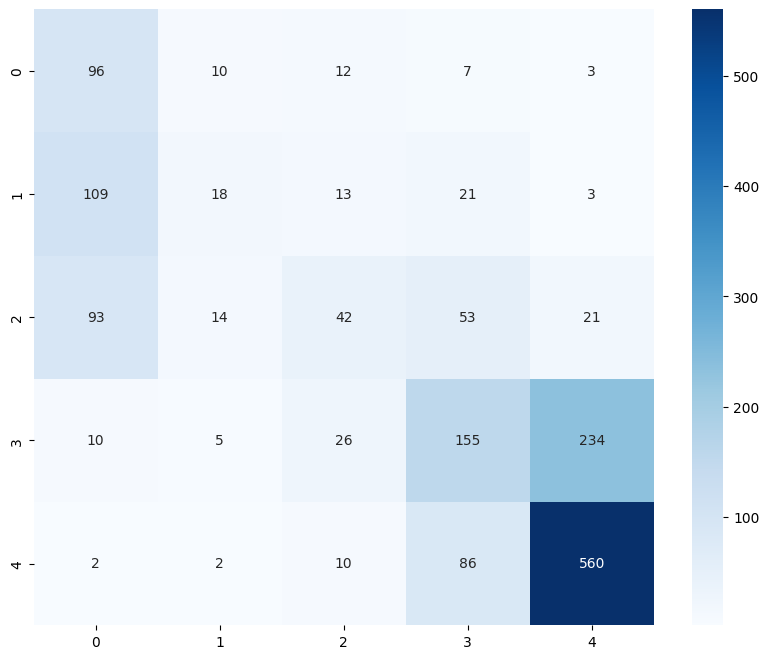

In [53]:
# Matrice de confusion
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))

# Rapport de classification détaillé
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=['0 étoiles', '1 étoile', '2 étoiles', '3 étoiles', '4 étoiles']))

In [ ]:
# Fonction pour prédire la note d'une nouvelle critique
def predict_review_rating(text, tokenizer, model, maxlen):
    processed_text = preprocess_text(text)
    
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded = pad_sequences(sequence, maxlen=maxlen)
    
    prediction = model.predict(padded)[0]
    rating = np.argmax(prediction)
    confidence = prediction[rating]
    
    return rating, confidence, prediction

In [ ]:
test_reviews = [
    "Came here for a business dinner seminar. The staff was awesome and the food and cocktails were really good too.",
    "Never had a greater dinner in my life. Go !!!",
    "If you want to pay for everything a la carte this is the place for you.  \nFood wasn't terrible not impressive.\nThey brought a basket of chips and some tomato sauce which I asked politely for something spicier and some pico de gallo.  She brought them happily to me and the salsa was much better.  When asked what we would like to drink I asked for a coke and she brought out a bottle which I stated I wanted the fountain drink.  She said \"oh that's only Pepsi\".  Never mentioned that they only had bottle drinks for coke.  \nWe ordered our food which was reasonably priced, asked for sour cream and also to put cheese on the taco.  She let us know cheese was extra.  \nIt was $2.50 extra for another basket of chips.  \nWhen I received the bill we paid more for the condiments then the actual food.  Side of sour cream 2.00, pico de gallo 2.50, salsa 2.00, chips 2.50, cheese 1.00 and the bottled coke that we didn't want 5.00.  \nJust a suggestion...when you order anything make sure to ask if there is an extra charge.",
    "I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!"
]

print("\nPrédictions sur des exemples:")
for review in test_reviews:
    rating, confidence, probs = predict_review_rating(review, tokenizer, model, maxlen)
    print(f"Critique: {review[:100]}...")
    print(f"Note prédite: {rating} étoiles (confiance: {confidence:.2f})")
    print(f"Probabilités par classe: {probs}")
    print("-" * 50)

model.save('yelp_rnn_classifier.h5')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, open('tokenizer.pickle', 'wb'))

print("Modèle et tokenizer sauvegardés avec succès!")


Prédictions sur des exemples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Critique: Came here for a business dinner seminar. The staff was awesome and the food and cocktails were reall...
Note prédite: 5 étoiles (confiance: 0.51)
Probabilités par classe: [0.00315991 0.01394678 0.02407764 0.09143359 0.3620263  0.5053557 ]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Critique: Never had a greater dinner in my life. Go !!!...
Note prédite: 4 étoiles (confiance: 0.29)
Probabilités par classe: [0.01547982 0.08799162 0.11452487 0.21547005 0.29430872 0.2722249 ]
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Critique: If you want to pay for everything a la carte this is the place for you.  
Food wasn't terrible not i...
Note prédite: 1 étoiles (confiance: 0.34)
Probabilités par classe: [0.0159348  0.34467432 0.329163   0.21379712 0.07179248 0.0246383 ]
--------------------------------------------------
1/1 ━━━━━━